In [81]:
# Importar librerias
import numpy as np
import pickle
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [82]:
# Importar dataset
class Dataset:
    
    instance = None
    data = None
    
    def __new__(cls, fname):
        if Dataset.instance is None:
            print("Creating new dataset instance")
            Dataset.instance = super(Dataset, cls).__new__(cls)
            return Dataset.instance
        else:
            return Dataset.instance
        
    def __init__(self, fname):
        print("Initialising dataset")
        
        try:
            with open(fname + '.pkl','rb') as pkl_file:
                self.data = pickle.load(pkl_file)
        except FileNotFoundError:
            print("CSV file found. Building PKL file...")
            try:
                with open(fname + '.csv') as csv_file:
                    with open(fname + '.pkl','wb') as pkl_file:
                        
                        csv_reader = csv.reader(csv_file, delimiter=',')

                        def generator(csv_reader):
                            for line in csv_reader:
                                yield(line[0],line[1])
                        
                        gen = generator(csv_reader)
                        
                        structure = [('X', np.float32),
                                     ('y', np.float32)]
                        
                        array = np.fromiter(gen, dtype=structure)
                        
                        pickle.dump(array, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)
                        
                    pkl_file.close()
                
                with open(fname + '.pkl','rb') as pkl_file:
                    self.data = pickle.load(pkl_file)
            except FileNotFoundError:
                print("No PKL or CSV named " + fname + " was found.")
            finally:
                csv_file.close()
        finally:
            pkl_file.close()

dataset = Dataset('clase_8_dataset')

Creating new dataset instance
Initialising dataset


(500,)
(500,)


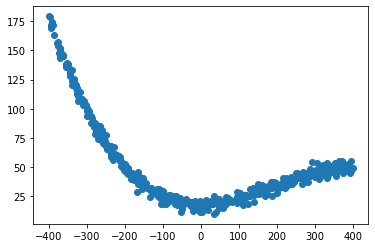

In [83]:
# Graficar dataset
X = dataset.data['X']
y = dataset.data['y']

plt.scatter(X,y);
print(X.shape)
print(y.shape)

In [84]:
# Normalizar el dataset
X = StandardScaler(with_std=True).fit_transform(X.reshape(-1, 1))

In [85]:
# Dividir dataset
def splitDataset(X, y, p):
    
    idx = np.random.permutation(X.shape[0])
    X_sh = X[idx]
    y_sh = y[idx]
    
    lim = int(X.shape[0]*p)

    return X_sh[:lim], X_sh[lim:], y_sh[:lim], y_sh[lim:]

X_train, X_test, y_train, y_test = splitDataset(X, y, 0.8)

In [86]:
# Regresión Lineal
class LinearRegression():

    def fit(self, x, y):
        if x.ndim == 1:
            w = (x.T @ y) / (x.T @ x)
        else:
            w = np.linalg.inv(x.T @ x) @ x.T @ y
        self.model = w

    def predict(self, x):
        return self.model @ x

In [87]:
# Regresión Polinómica
class PolynomialRegression(LinearRegression):

    def __init__(self, grade):
        self.poly = PolynomialFeatures(grade)

    def fit(self, x, y):
        res = self.poly.fit_transform(x.reshape(-1, 1))
        super().fit(res, y.reshape(-1, 1))

    def predict(self, x):
        return self.poly.fit_transform(x.reshape(-1, 1)) @ self.model

    def fit_transform(self, x, y):
        self.fit(x, y)
        return self.predict(x).reshape(1, -1)

In [88]:
class MSE():
    def __call__(self, target, prediction):
        return np.mean((target - prediction) ** 2)

In [89]:
# K-folds
def k_folds(X, y, k, n):
    
    p_reg = PolynomialRegression(n)

    mse_eval = MSE()
    mse_list = []

    chunk_size = int(len(X) / k)

    for i in range(0, len(X), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X) else len(X)

        X_valid = X[i: end]
        y_valid = y[i: end]
        X_train = np.concatenate([X[: i], X[end:]])
        y_train = np.concatenate([y[: i], y[end:]])

        p_reg.fit(X_train, y_train)
        y_pred = p_reg.predict(X_valid)
        
#         plt.figure()
#         plt.scatter(X_valid, y_valid)
#         plt.scatter(X_valid,y_pred)
        
        k_mse = mse_eval(y_valid.reshape(-1, 1), y_pred)
        
        mse_list.append(k_mse)
        
    mean_mse = np.mean(mse_list)

    return mean_mse

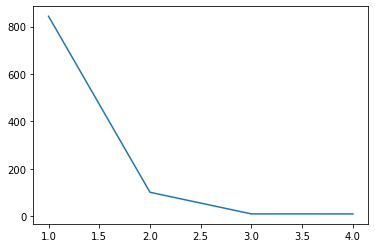

In [90]:
# Usar k-folds por cada grado de regresion polinómica de 1 a 4
grades = [1,2,3,4]
mses = []

for g in grades:
    mse = k_folds(X_train, y_train, 5, g)
    mses.append(mse)
    
plt.plot(grades, mses);

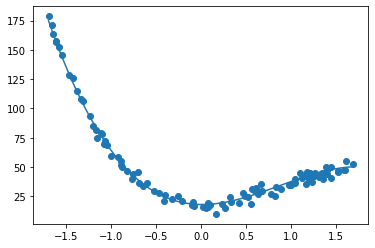

In [91]:
# Selección del mejor modelo (polinomio grado 3)
p_reg = PolynomialRegression(3)
yp_train = p_reg.fit_transform(X_train, y_train)
yp_test = p_reg.predict(X_test)

w_cl = p_reg.model
x = np.linspace(X_test.min(),X_test.max(), 100)
y_cl = w_cl[0] * x**0 + w_cl[1] * x**1 + w_cl[2] * x**2 + w_cl[3] * x**3

plt.plot(x,y_cl)
plt.scatter(X_test, y_test);

In [79]:
# Mini-Batch Gradient Descent
class MiniBatchGradientDescent:

    def __init__(self, alpha, n_epochs, n_batches, poly=None, lbd=0):
        self.alpha = alpha
        self.n_epochs = n_epochs
        self.model = None
        self.n_batches = n_batches
        self.lbd = lbd

        if poly is not None:
            self.poly = PolynomialFeatures(poly)
        else:
            self.poly = None

    def fit(self, x, y):
        
        if self.poly is not None:
            x = self.poly.fit_transform(x.reshape(-1, 1))

        if x.ndim == 1:
            x = x.reshape(-1, 1)

        n_samples = x.shape[0]
        n_features = x.shape[1]
        
        # Mantener 1/5 del dataset para validacion
        idx = np.random.permutation(n_samples)
        x_sh = x[idx]
        y_sh = y[idx]
        lim = int(n_samples*4/5)
        x = x_sh[:lim]
        y = y_sh[:lim]
        x_val = x_sh[lim:]
        y_val = y_sh[lim:]
        n_samples = x.shape[0]

        # 1 - Random w initialization
        w = np.random.random(n_features)

        for epoch in range(self.n_epochs):
            # Shuffle samples and create batches
            batch_size = int(n_samples / self.n_batches)
            idx = np.random.permutation(n_samples)
            x_sh = x[idx]
            y_sh = y[idx]

            for i in range(self.n_batches):
                bx = x_sh[i * batch_size:(i + 1) * batch_size]
                by = y_sh[i * batch_size:(i + 1) * batch_size]
                reg_factor = 1 - 2 * self.lbd * self.alpha
                w = reg_factor * w - self.alpha * (-2 / n_samples) * np.sum((by - bx @ w)[:, np.newaxis] * bx, axis=0)
        
            mse_eval = MSE()
            train_error = mse_eval(y_sh, x_sh @ w).round(decimals=1)
            validation_error = mse_eval(y_val, x_val @ w).round(decimals=1)
            print("Epoch: " + str(epoch) + " | Training error: " + str(train_error) + " Validation error: " + str(validation_error))
        
        self.model = w

    def predict(self, x):

        if self.poly is not None:
            x = self.poly.fit_transform(x.reshape(-1, 1))

        if x.ndim == 1:
            x = x.reshape(-1, 1)

        return x @ self.model

    def fit_transform(self, x, y):
        self.fit(x, y)
        return self.predict(x).reshape(1, -1)


In [80]:
bt = MiniBatchGradientDescent(alpha=0.1, n_epochs=50, n_batches=15, poly=3, lbd=0.001)
bt.fit(X_train, y_train)

y_pred = bt.predict(X_test)

plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred);

ValueError: operands could not be broadcast together with shapes (21,1,21) (21,4) 

[[ 18.08207    -0.7965448  33.065804  -12.708985 ]]
[ 18.00813472  -2.42488046  32.85248976 -11.82022795]


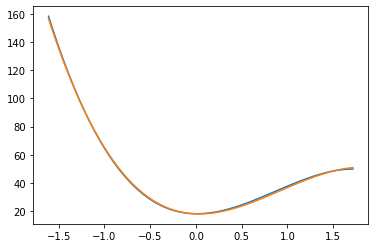

In [38]:
# Comparación de la solución cerrada con Mini-Batch
w_bt = bt.model
x = np.linspace(X_test.min(),X_test.max(), 100)
y_bt = w_bt[0] * x**0 + w_bt[1] * x**1 + w_bt[2] * x**2 + w_bt[3] * x**3

print(w_cl.T)
print(w_bt)

plt.plot(x,y_cl)
plt.plot(x,y_bt);